In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostRegressor
import pickle

In [2]:
df = pd.read_csv('data.csv')
df.columns

Index(['TEXT__WORD_HIGHLIGHTED_seconds', 'TEXT__WORD_HIGHLIGHTED_amount',
       'TEXT__SENTENCE_CLICK_seconds', 'TEXT__SENTENCE_CLICK_amount',
       'TEXT__SENTENCE_READ_seconds', 'TEXT__SENTENCE_READ_amount',
       'REVISION__CLICKED_seconds', 'REVISION__CLICKED_amount',
       'REVISION__NOT_CLICKED_seconds', 'REVISION__NOT_CLICKED_amount',
       'VIDEO__WAS_SEEN_seconds', 'VIDEO__WAS_SEEN_amount',
       'VIDEO__TRANSLATION_WAS_REVEALED_seconds',
       'VIDEO__TRANSLATION_WAS_REVEALED_amount', 'BOOK_DRILL_CLICK_seconds',
       'BOOK_DRILL_CLICK_amount', 'BOOK_DRILL_SCROLL_seconds',
       'BOOK_DRILL_SCROLL_amount', 'FIRST_EXPOSURE_seconds', 'delta',
       'ALL_longest_leading_recalls_seconds', 'ALL_leading_recalls_amount',
       'ALL_leading_recalls_seconds', 'ALL_leading_failures_amount',
       'ALL_leading_failures_seconds', 'ALL_amount', 'score', 'score_prev',
       'user_lang'],
      dtype='object')

In [3]:
from abc import ABC, abstractmethod

class IMemoryTraceFunctionalForm(ABC):
    """
    Infers mu from p and delta, and also delta from mu and p
    """

    @staticmethod
    @abstractmethod
    def calculate_mu(retention_rate, delta):
        pass

    @staticmethod
    @abstractmethod
    def calculate_retention_rate(mu, delta):
        pass

    @staticmethod
    @abstractmethod
    def get_name():
        pass


class ExponentialSqrt(IMemoryTraceFunctionalForm):

    @staticmethod
    def calculate_mu(retention_rate, delta):
        retention_rate_clipped = np.clip(retention_rate, 0.1, 0.9)
        return (-1 * np.sqrt(delta + 1)) / np.log(retention_rate_clipped)

    @staticmethod
    def calculate_retention_rate(mu, delta):
        exponent = -1 * np.sqrt(delta + 1) / mu
        return np.exp(exponent)

    @staticmethod
    def get_name():
        return "ESq"


class Exponential(IMemoryTraceFunctionalForm):

    @staticmethod
    def calculate_mu(retention_rate, delta):
        retention_rate_clipped = np.clip(retention_rate, 0.1, 0.9)
        return (-1 * delta) / np.log(retention_rate_clipped)

    @staticmethod
    def calculate_retention_rate(mu, delta):
        exponent = -1 * delta / mu
        return np.exp(exponent)

    @staticmethod
    def get_name():
        return "Exp"


class Hyperbolic(IMemoryTraceFunctionalForm):

    @staticmethod
    def calculate_mu(retention_rate, delta):
        retention_rate_clipped = np.clip(retention_rate, 0.1, 0.9)
        return np.divide(np.multiply(delta, retention_rate), 1. - retention_rate_clipped)

    @staticmethod
    def calculate_retention_rate(mu, delta):
        return np.divide(1., 1. + np.divide(delta, mu))

    @staticmethod
    def get_name():
        return "Hyp"


class HyperbolicSqrt(IMemoryTraceFunctionalForm):

    @staticmethod
    def calculate_mu(retention_rate, delta):
        retention_rate_clipped = np.clip(retention_rate, 0.1, 0.9)
        return np.divide(np.multiply(np.sqrt(delta), retention_rate), 1. - retention_rate_clipped)

    @staticmethod
    def calculate_retention_rate(mu, delta):
        return np.divide(1., 1. + np.divide(np.sqrt(delta), mu))

    @staticmethod
    def get_name():
        return "HSq"


class HLR(IMemoryTraceFunctionalForm):

    @staticmethod
    def calculate_mu(retention_rate, delta):
        retention_rate_clipped = np.clip(retention_rate, 0.001, 0.999)
        term = (-1 * delta) / np.log2(retention_rate_clipped)
        return np.log2(term)

    @staticmethod
    def calculate_retention_rate(mu, delta):
        exponent = np.divide(-1 * delta, np.power(2., mu))
        return np.power(2., exponent)

    @staticmethod
    def get_name():
        return "HLR"

In [4]:
MU_MAX = 10e10
MU_MIN = 10e-10
MAX_ELAPSED = 62208000


class SimplifiedWickelgren:

    @staticmethod
    def calculate_mu(retention_rate, delta):
        delta_ = delta / (24 * 60 * 60)
        retention_rate_clipped = np.clip(retention_rate, 0.1, 0.95)
        return -1. * np.divide(np.log(1 + delta_), (np.log(retention_rate_clipped)))

    @staticmethod
    def calculate_retention_rate(mu, delta):
        delta_ = delta / (24 * 60 * 60)
        mu = np.clip(mu, MU_MIN, MU_MAX)
        exponent = np.divide(-1.,mu)
        return np.power(1. + delta_, exponent)

    @staticmethod
    def get_name():
        return "SWP"

    
class HLRSqrt:

    @staticmethod
    def calculate_mu(retention_rate, delta):
        delta_sqrt = np.sqrt(delta)
        retention_rate_clipped = np.clip(retention_rate, 0.001, 0.999)
        term = (-1 * delta_sqrt) / np.log2(retention_rate_clipped)
        mu = np.log2(term)
        return np.clip(mu+5, 5, MU_MAX)


    @staticmethod
    def calculate_retention_rate(mu, delta):
        delta_sqrt = np.sqrt(delta)
        mu = np.clip(mu, MU_MIN, MU_MAX)
        exponent = np.divide(-1 * delta_sqrt, np.power(2.,mu-5))
        return np.power(2., exponent)

    @staticmethod
    def get_name():
        return "HLR"
    
class MTR:
    def __init__(self):
        self.model = LinearRegression
        self.column_names = []
    
    def load(self):
        with open('model.pkl', 'rb') as file:
            self.model = pickle.load(file)
        
        with open('column_names.pkl', 'rb') as file:
            self.column_names = pickle.load(file)
    
    def predict_to_df(self, df):
        X = df[self.column_names]
        delta = df['delta']
        mu_pred = self.model.predict(X)
        df['score_pred'] = SimplifiedWickelgren.calculate_retention_rate(mu_pred, delta)
        return df
        

def engineer_features(X):
    result = pd.DataFrame()
    result[X.columns] = X
    for feature_name in X.columns:
        if 'seconds' in feature_name:
            mask = X[feature_name].where((0<X[feature_name]) & (X[feature_name]<MAX_ELAPSED))
            
            sqrt = np.sqrt(mask)
            result[feature_name+"_sqrt"] = np.nan_to_num(sqrt)

            inverse = np.clip(np.divide(1.0, mask), 10e-10, 10e-6)
            result[feature_name+"_inverse"] = np.nan_to_num(inverse)
            
            log_inverse = np.sqrt(inverse)
            result[feature_name+"_sqrt_inverse"] = np.nan_to_num(log_inverse)
            
            if 'FIRST_EXPOSURE' in feature_name:
                continue
                
            result.drop(feature_name, axis=1, inplace=True)
        if 'amount' in feature_name:
            result[feature_name+"_sqrt"] = np.sqrt(X[feature_name])
            result.drop(feature_name, axis=1, inplace=True)

    return result


In [5]:
def undersample_successes(df_):
    failures = df_[df_['score'] < 0.5]
    successes = df_[df_['score'] >= 0.5].sample(len(failures))
    return pd.concat([failures, successes])

In [6]:
# Subset by user
FEATURES_TO_DROP = ['score', 'delta', 'score_prev', 'user_lang']
df_user = df.loc[df['user_lang'] == 'charlie_de']
# df_user = df
# df_ = undersample_successes(df_user)
# df_ = df_user.reset_index()[100:200]
df_ = df_user.iloc[100:200]
df_2 = df_user.iloc[1000:2000]

X = df_.drop(FEATURES_TO_DROP, axis=1)
# X.sort_index(axis=1, inplace=True)
# X = engineer_features(X)
scaler = MinMaxScaler()
X[X.columns] = scaler.fit_transform(X)

score = df_['score']
score_prev = df_['score_prev']
delta = df_['delta']
delta_prime = df_[['delta', 'ALL_longest_leading_recalls_seconds']].max(axis=1)

# df_delta = pd.DataFrame({'delta': df_['delta']})
df_delta = pd.DataFrame({'delta': delta_prime})
df_delta[df_delta.columns] = MinMaxScaler().fit_transform(df_delta)
delta_scaled = df_delta['delta']
# weights = 0. + np.power(np.multiply(1- score,delta_scaled),2)
# weights = 1.1-score
weights = np.power(np.multiply(score_prev- score,delta_scaled), 2)

# weights = None

# Calculate mu
mu = SimplifiedWickelgren.calculate_mu(score, delta_prime)

# Fit for mu
model = LinearRegression()
model.fit(X, score)
X_test = df_2.drop(FEATURES_TO_DROP, axis=1)
X_test = scaler.transform(X_test)
mu_pred = np.clip(model.predict(X_test), 0, 1)
# score_pred = SimplifiedWickelgren.calculate_retention_rate(mu_pred,delta_scaled)
score_pred = mu_pred

summary = model_performance(model, score_pred, score_pred)
summary.mean()

NameError: name 'model_performance' is not defined

In [ ]:
len(df_user)

/home/charlie/.local/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


mu                  22.000496
mu_pred             23.750301
score                0.861139
score_pred           0.835190
mae                  0.192403
mse                  0.110505
optimism            -0.025950
wmse_tau             0.016724
wmse_delta_tau       0.000141
weighted_bin_acc     0.553494
precision            0.032935
recall               0.238395
dtype: float64

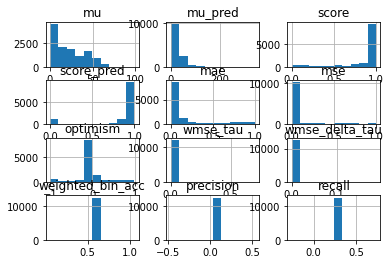

In [12]:
from sklearn.metrics import balanced_accuracy_score

def model_performance(df):
#     mu_pred_2d = np.clip(model.predict(X), MU_MIN, MU_MAX)
#     mu_pred = mu_pred_2d.reshape(-1)
    # score_pred = np.clip(mu_pred, 0, 1)

    # score_pred = SimplifiedWickelgren.calculate_retention_rate(mu_pred,delta)

    wmse_delta_tau = np.power(np.multiply(np.multiply(df['score_prev']- df['score'],df['delta_scaled']), df['score']-df['score_pred']), 2)
    wmse_tau       = np.power(np.multiply(df['score_prev']- df['score'], df['score']-df['score_pred']), 2)
    summary = pd.DataFrame({
        'mu': df['mu'],
        'mu_pred': df['mu_pred'],
        'score': df['score'],
        'score_pred': df['score_pred'],
        'mae': np.abs(df['score']-df['score_pred']),
        'mse': np.multiply((df['score']-df['score_pred']), (df['score']-df['score_pred'])),
        'optimism': df['score_pred']-df['score'],
        'wmse_tau': wmse_tau,
        'wmse_delta_tau': wmse_delta_tau,
        'weighted_bin_acc': balanced_accuracy_score(df['score']>0.5, df['score_pred']>0.5),
        'precision': precision(df),
        'recall': recall(df)
    })
    summary.hist()
    return summary

def precision(df):
    THRESHOLD = 0.6
    predicted_negatives = df['score_pred'] <= THRESHOLD
    actual_negatives    = df['score'] <= THRESHOLD
    true_predicted_negatives = actual_negatives & predicted_negatives
    all_negatives = predicted_negatives | actual_negatives
    
    if not len(df[predicted_negatives]):
        return 1
    return len(df[true_predicted_negatives]) / len(predicted_negatives)
    
def recall(df):
    THRESHOLD = 0.6
    predicted_negatives = df['score_pred'] <= THRESHOLD
    actual_negatives    = df['score'] <= THRESHOLD
    true_predicted_negatives = actual_negatives & predicted_negatives
    all_negatives = predicted_negatives | actual_negatives
    
    if not len(df[all_negatives]):
        return 1
    return len(df[true_predicted_negatives])/len(df[actual_negatives])

model_performance(df_user).mean()

In [ ]:
summary['mu_pred'].hist(alpha=0.3)
summary['mu'].hist(alpha=0.3)

In [ ]:
summary.plot.scatter(x='mu', y='mu_pred', alpha=0.05)
summary.plot.scatter(x='score', y='score_pred', s=100, alpha=0.1)
# summary['score_pred'].hist()
# summary['score'].hist()

In [ ]:
X

In [ ]:
# Save columns
# with open('column_names.pkl', 'wb') as file:
#     pickle.dump(columns, file)

In [ ]:
# Neural network
scaler = MinMaxScaler()
X_extended = engineer_features(X)
X_scaled = scaler.fit_transform(X)

from tensorflow.keras.layers import Input, Dense, Layer, BatchNormalization
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanSquaredError
general_input = Input(shape=[len(X.columns)])
general_hidden_1 = Dense(20)(general_input)
# general_hidden_2 = Dense(15, activation="relu")(general_hidden_1)
# general_hidden_3 = Dense(8, activation="relu")(general_hidden_2)
# general_hidden_4 = Dense(4, activation="relu")(general_hidden_3)
# general_hidden_5 = Dense(2, activation="relu")(general_hidden_4)
general_hidden_last = Dense(10, activation='relu')(general_hidden_1)
general_output = Dense(1, activation='relu')(general_hidden_last)
# general_output = Dense(1, activation='exponential')(general_output_pre)
model = Model(inputs=[general_input], outputs=[general_output,])
# Get data
# model.fit(X, mu, epochs=1000, batch_size=100, sample_weight=weights)

In [ ]:
# model.compile(loss='mse', optimizer="adam", metrics=['mse'])
model.compile(loss='mse', optimizer="adam", metrics=['mse'])
for i in range(1):
    model.fit(X_scaled, mu, epochs=1000, sample_weight=None)
#     model.fit(X, mu, epochs=1, batch_size=100)
    mu_pred_2d = np.clip(model.predict(X_scaled), MU_MIN, MU_MAX)
    mu_pred = mu_pred_2d.reshape(-1)
    summary = pd.DataFrame({
    'mu': mu,
    'mu_pred': mu_pred,
    'score': score,
    'score_pred': SimplifiedWickelgren.calculate_retention_rate(mu_pred,delta)
    })
    ax = summary.plot.scatter(x='mu', y='mu_pred', s=100, alpha=0.05)
    ax.get_figure().savefig(f'plots/mu{str(i).zfill(3)}.png', dpi=300)
    ax = summary.plot.scatter(x='score', y='score_pred', s=100, alpha=0.05)
    ax.get_figure().savefig(f'plots/score{str(i).zfill(3)}.png', dpi=300)


In [ ]:
# model.save('keras_model')
mu_pred_2d = np.clip(model.predict(X_scaled), MU_MIN, MU_MAX)
mu_pred = mu_pred_2d.reshape(-1)
model_performance(model, mu_pred, SimplifiedWickelgren.calculate_retention_rate(mu_pred,delta))

In [ ]:
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [ ]:
with open('scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)
scaler.transform

In [ ]:
probabilities_filtered = df.loc[(df['delta'] <= 10*24*60*60) & (df['score'] <= 1)]
probabilities_filtered_sorted = probabilities_filtered.sort_values('score', ascending=False)
# result = []
for i in range(min(len(probabilities_filtered_sorted), 10)):
    por = probabilities_filtered_sorted.loc[i]['score']

In [ ]:
por

In [ ]:
for i in range(1, 365*2):
    delta_offset = delta + i*12*60*60
    ax = SimplifiedWickelgren.calculate_retention_rate(mu,delta_offset).hist()
    ax.get_figure().savefig(f'plots/score_dist{str(i).zfill(3)}.png')
    ax.clear()

In [ ]:
df.loc[0:1].loc[0:10]

In [ ]:
df_.iloc[0:100]

In [8]:
from tensorflow.keras.layers import Input, Dense, Layer, BatchNormalization
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping

MU_INDIVIDUAL = 'mu_individual'
MU_GENERAL = 'mu_general'

class IncrementalMTR:
    
    @classmethod
    def from_general_model():
        pass
    
    @classmethod
    def from_saved_model():
        pass
    
    def save(self, filename):
        pass

    def fit_general(self, X, mu, epochs=2000, weights=None):

        self.scaler = MinMaxScaler()
        X_extended = engineer_features(X)
        X_scaled = scaler.fit_transform(X)
        
        target = pd.DataFrame({
            MU_INDIVIDUAL: mu,
            MU_GENERAL: mu
        })
        
        general_input = Input(shape=[len(X.columns)])
        general_hidden_1 = Dense(30)(general_input)
#         general_hidden_last = Dense(10, activation='relu')(general_hidden_1)
        general_output = Dense(2, activation='relu')(general_hidden_1)
        self.model = Model(inputs=[general_input], outputs=[general_output,])

        self.model.compile(loss='mae', optimizer="adam", metrics=['mse', 'mae'])
        print("Fitting general model")            
        callback = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=False)
        self.model.fit(X_scaled, target, epochs=epochs, sample_weight=weights, validation_split=0.2, callbacks=[callback,])

    def fit_individual_model(self, X, mu, epochs=100, weights=None):
        mu_pred = self.predict_both(X)
        
        target = pd.DataFrame({
            MU_INDIVIDUAL: mu,
            MU_GENERAL: mu_pred[:,1]
        })
        
        X_extended = engineer_features(X)
        X_scaled = scaler.fit_transform(X) 
        
        callback = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=False)
        self.model.fit(X_scaled, target, epochs=epochs, sample_weight=weights, validation_split=0.2, callbacks=[callback,])

    def predict_both(self, X):
        X_extended = engineer_features(X)
        X_scaled = scaler.fit_transform(X) 

        return self.model.predict(X_scaled)
    
    def predict(self, X):
        return self.predict_both(X)[:,0]
        
    def evaluate(self, X_general, mu_general, X_user, mu_user, batch_size=100, epochs=100, weights_user=None, weights_general=None):
        self.fit_general(X_general, mu_general, epochs=epochs, weights=weights_general)

        result = np.array([])
        for i in range(0, len(mu_user), batch_size):
            X, mu = X_user.iloc[i:i+batch_size], mu_user.iloc[i:i+batch_size]
            weights = None
            if weights_user is not None:
                weights = weights_user.iloc[i:i+batch_size]
            mu_pred = self.predict(X)
            result = np.concatenate((result, mu_pred), axis=0)
            self.fit_individual_model(X, mu, epochs=epochs, weights=weights)
            
        return result    

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [9]:
# TODO Prepare df
# TODO Early stop 
# How does lin reg fare in one user out?
#

functional_form = SimplifiedWickelgren

df['score_pred'] = np.ones([len(df)])
df['mu_pred'] = np.ones([len(df)])

USER = 'charlie_dansk_da'

delta = df['delta']
delta_prime = df[['delta', 'ALL_longest_leading_recalls_seconds']].max(axis=1)
df['mu'] = functional_form.calculate_mu(df['score'], delta_prime)

df_delta = pd.DataFrame({'delta': delta_prime})
df_delta[df_delta.columns] = MinMaxScaler().fit_transform(df_delta)
df['delta_scaled'] = df_delta['delta']
# df['weight'] = 1000*np.power(np.multiply(df['delta_scaled'],df['score']-df['score_prev']),2)
weigh(df)
                                            
df_not_user = df.loc[df['user_lang'] != USER]
df_user = df.loc[df['user_lang'] == USER]

FEATURES_TO_DROP = ['score', 'delta', 'score_prev', 'user_lang', 'mu', 'mu_pred', 'score_pred']

X_general = df_not_user.drop(FEATURES_TO_DROP, axis=1)
mu_general = df_not_user['mu']

X_user = df_user.drop(FEATURES_TO_DROP, axis=1)
mu_user = df_user['mu']

k_model = IncrementalMTR()
result = k_model.evaluate(X_general, 
                          mu_general, 
                          X_user, 
                          mu_user, 
                          batch_size=2000, 
                          epochs=2000, 
#                           weights_user=df_user['weight'],
                          weights_general = df_not_user['weight']
                         )

<ipython-input-7-316265b17c36>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weight'][df['score']<=THRESHOLD] = weight0
<ipython-input-7-316265b17c36>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weight'][df['score']>THRESHOLD] = weight1


Fitting general model
Epoch 1/2000
146/146 [==============================] - 1s 3ms/step - loss: 8.2949 - mse: 592.2727 - mae: 16.5899 - val_loss: 13.0746 - val_mse: 1324.8619 - val_mae: 26.1492
Epoch 2/2000
146/146 [==============================] - 0s 1ms/step - loss: 7.7708 - mse: 462.3759 - mae: 15.5415 - val_loss: 12.3865 - val_mse: 1111.3639 - val_mae: 24.7730
Epoch 3/2000
146/146 [==============================] - 0s 2ms/step - loss: 7.5470 - mse: 386.8853 - mae: 15.0940 - val_loss: 11.7394 - val_mse: 959.6118 - val_mae: 23.4789
Epoch 4/2000
146/146 [==============================] - 0s 1ms/step - loss: 7.1887 - mse: 330.5279 - mae: 14.3774 - val_loss: 11.0880 - val_mse: 849.1275 - val_mae: 22.1760
Epoch 5/2000
146/146 [==============================] - 0s 2ms/step - loss: 6.7878 - mse: 311.4750 - mae: 13.5755 - val_loss: 10.1941 - val_mse: 701.9760 - val_mae: 20.3882
Epoch 6/2000
146/146 [==============================] - 0s 1ms/step - loss: 6.4573 - mse: 274.4248 - mae: 12.91

146/146 [==============================] - 0s 1ms/step - loss: 4.9337 - mse: 204.3935 - mae: 9.8674 - val_loss: 8.2952 - val_mse: 712.7147 - val_mae: 16.5904
Epoch 96/2000
146/146 [==============================] - 0s 1ms/step - loss: 5.0572 - mse: 211.6514 - mae: 10.1145 - val_loss: 8.2745 - val_mse: 705.2879 - val_mae: 16.5489
Epoch 97/2000
146/146 [==============================] - 0s 1ms/step - loss: 4.9985 - mse: 208.9422 - mae: 9.9969 - val_loss: 8.2710 - val_mse: 709.5484 - val_mae: 16.5421
Epoch 98/2000
146/146 [==============================] - 0s 1ms/step - loss: 5.1306 - mse: 224.5060 - mae: 10.2612 - val_loss: 8.2692 - val_mse: 709.4688 - val_mae: 16.5384
Epoch 99/2000
146/146 [==============================] - 0s 1ms/step - loss: 4.9393 - mse: 207.9122 - mae: 9.8786 - val_loss: 8.2816 - val_mse: 709.8583 - val_mae: 16.5632
Epoch 100/2000
146/146 [==============================] - 0s 1ms/step - loss: 5.2027 - mse: 236.7805 - mae: 10.4055 - val_loss: 8.2873 - val_mse: 717.47

50/50 [==============================] - 0s 2ms/step - loss: 3.0124 - mse: 71.7685 - mae: 3.0124 - val_loss: 3.5773 - val_mse: 45.9384 - val_mae: 3.5773
Epoch 83/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.0101 - mse: 71.4380 - mae: 3.0101 - val_loss: 3.5756 - val_mse: 45.8617 - val_mae: 3.5756
Epoch 84/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.0101 - mse: 71.5416 - mae: 3.0101 - val_loss: 3.5610 - val_mse: 45.8127 - val_mae: 3.5610
Epoch 85/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.0080 - mse: 71.3878 - mae: 3.0080 - val_loss: 3.5603 - val_mse: 45.8350 - val_mae: 3.5603
Epoch 86/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.0067 - mse: 71.3503 - mae: 3.0067 - val_loss: 3.5764 - val_mse: 46.1584 - val_mae: 3.5764
Epoch 87/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.0032 - mse: 71.3554 - mae: 3.0032 - val_loss: 3.5801 - val_mse: 46.3912 - val_mae: 3.5801
Epoch 88/200

50/50 [==============================] - 0s 2ms/step - loss: 4.4309 - mse: 83.8704 - mae: 4.4309 - val_loss: 4.7052 - val_mse: 89.4355 - val_mae: 4.7052
Epoch 18/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.4196 - mse: 83.5672 - mae: 4.4196 - val_loss: 4.7113 - val_mse: 89.5569 - val_mae: 4.7113
Epoch 19/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.4054 - mse: 83.5092 - mae: 4.4054 - val_loss: 4.6807 - val_mse: 88.7737 - val_mae: 4.6807
Epoch 20/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.3935 - mse: 83.0634 - mae: 4.3935 - val_loss: 4.6756 - val_mse: 88.7046 - val_mae: 4.6756
Epoch 21/2000
50/50 [==============================] - 0s 3ms/step - loss: 4.3845 - mse: 82.9765 - mae: 4.3845 - val_loss: 4.6747 - val_mse: 88.5756 - val_mae: 4.6747
Epoch 22/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.3722 - mse: 82.9427 - mae: 4.3722 - val_loss: 4.6657 - val_mse: 88.4291 - val_mae: 4.6657
Epoch 23/200

Epoch 115/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.2738 - mse: 103.8214 - mae: 3.2738 - val_loss: 3.5182 - val_mse: 105.7333 - val_mae: 3.5182
Epoch 116/2000
50/50 [==============================] - 0s 3ms/step - loss: 3.2655 - mse: 104.4962 - mae: 3.2655 - val_loss: 3.4929 - val_mse: 106.4741 - val_mae: 3.4929
Epoch 117/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.2559 - mse: 105.5345 - mae: 3.2559 - val_loss: 3.5148 - val_mse: 107.8699 - val_mae: 3.5148
Epoch 118/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.2462 - mse: 105.9521 - mae: 3.2462 - val_loss: 3.4784 - val_mse: 108.5795 - val_mae: 3.4784
Epoch 119/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.2308 - mse: 107.1325 - mae: 3.2308 - val_loss: 3.4421 - val_mse: 108.5607 - val_mae: 3.4421
Epoch 120/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.2278 - mse: 108.3470 - mae: 3.2278 - val_loss: 3.4201 - val_mse: 108.903

Epoch 163/2000
50/50 [==============================] - 0s 2ms/step - loss: 2.9658 - mse: 133.3003 - mae: 2.9658 - val_loss: 3.4290 - val_mse: 152.3349 - val_mae: 3.4290
Epoch 164/2000
50/50 [==============================] - 0s 2ms/step - loss: 2.9555 - mse: 134.3598 - mae: 2.9555 - val_loss: 3.3744 - val_mse: 150.8305 - val_mae: 3.3744
Epoch 165/2000
50/50 [==============================] - 0s 2ms/step - loss: 2.9519 - mse: 134.0633 - mae: 2.9519 - val_loss: 3.4020 - val_mse: 152.1212 - val_mae: 3.4020
Epoch 166/2000
50/50 [==============================] - 0s 3ms/step - loss: 2.9484 - mse: 134.9489 - mae: 2.9484 - val_loss: 3.4161 - val_mse: 153.8335 - val_mae: 3.4161
Epoch 167/2000
50/50 [==============================] - 0s 2ms/step - loss: 2.9446 - mse: 134.9416 - mae: 2.9446 - val_loss: 3.4024 - val_mse: 154.5944 - val_mae: 3.4024
Epoch 168/2000
50/50 [==============================] - 0s 2ms/step - loss: 2.9460 - mse: 135.3284 - mae: 2.9460 - val_loss: 3.3940 - val_mse: 154.055

50/50 [==============================] - 0s 2ms/step - loss: 4.5854 - mse: 209.8452 - mae: 4.5854 - val_loss: 4.7507 - val_mse: 120.0493 - val_mae: 4.7507
Epoch 15/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.5818 - mse: 208.8055 - mae: 4.5818 - val_loss: 4.7359 - val_mse: 118.2834 - val_mae: 4.7359
Epoch 16/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.5831 - mse: 206.7151 - mae: 4.5831 - val_loss: 4.7381 - val_mse: 117.8777 - val_mae: 4.7381
Epoch 17/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.5806 - mse: 206.4600 - mae: 4.5806 - val_loss: 4.7359 - val_mse: 117.0593 - val_mae: 4.7359
Epoch 18/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.5729 - mse: 205.0105 - mae: 4.5729 - val_loss: 4.7341 - val_mse: 115.4793 - val_mae: 4.7341
Epoch 19/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.5692 - mse: 203.3915 - mae: 4.5692 - val_loss: 4.7390 - val_mse: 117.1337 - val_mae: 4.7390


50/50 [==============================] - 0s 2ms/step - loss: 5.6717 - mse: 217.3531 - mae: 5.6717 - val_loss: 5.4875 - val_mse: 141.2995 - val_mae: 5.4875
Epoch 2/2000
50/50 [==============================] - 0s 2ms/step - loss: 5.0793 - mse: 174.2292 - mae: 5.0793 - val_loss: 5.1016 - val_mse: 129.4751 - val_mae: 5.1016
Epoch 3/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.8288 - mse: 161.8418 - mae: 4.8288 - val_loss: 4.8089 - val_mse: 114.4073 - val_mae: 4.8089
Epoch 4/2000
50/50 [==============================] - 0s 3ms/step - loss: 4.6600 - mse: 149.5515 - mae: 4.6600 - val_loss: 4.6020 - val_mse: 105.9157 - val_mae: 4.6020
Epoch 5/2000
50/50 [==============================] - 0s 3ms/step - loss: 4.5315 - mse: 141.4316 - mae: 4.5315 - val_loss: 4.4706 - val_mse: 100.5494 - val_mae: 4.4706
Epoch 6/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.4490 - mse: 137.0127 - mae: 4.4490 - val_loss: 4.3757 - val_mse: 92.3008 - val_mae: 4.3757
Epoch 

Epoch 50/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.1077 - mse: 104.6189 - mae: 4.1077 - val_loss: 4.0093 - val_mse: 74.7349 - val_mae: 4.0093
Epoch 51/2000
50/50 [==============================] - 0s 3ms/step - loss: 4.1047 - mse: 103.8752 - mae: 4.1047 - val_loss: 3.9992 - val_mse: 74.1667 - val_mae: 3.9992
Epoch 52/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.1007 - mse: 103.3918 - mae: 4.1007 - val_loss: 4.0029 - val_mse: 74.0334 - val_mae: 4.0029
Epoch 53/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.1038 - mse: 102.9951 - mae: 4.1038 - val_loss: 3.9985 - val_mse: 73.2465 - val_mae: 3.9985
Epoch 54/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0992 - mse: 102.3882 - mae: 4.0992 - val_loss: 3.9976 - val_mse: 74.5232 - val_mae: 3.9976
Epoch 55/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0957 - mse: 103.4604 - mae: 4.0957 - val_loss: 3.9983 - val_mse: 73.7774 - val_mae:

Epoch 99/2000
50/50 [==============================] - 0s 3ms/step - loss: 4.0764 - mse: 101.1261 - mae: 4.0764 - val_loss: 3.9649 - val_mse: 72.8576 - val_mae: 3.9649
Epoch 100/2000
50/50 [==============================] - 0s 3ms/step - loss: 4.0700 - mse: 100.2865 - mae: 4.0700 - val_loss: 3.9550 - val_mse: 72.8874 - val_mae: 3.9550
Epoch 101/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0700 - mse: 99.9764 - mae: 4.0700 - val_loss: 3.9529 - val_mse: 73.0449 - val_mae: 3.9529
Epoch 102/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0676 - mse: 99.9621 - mae: 4.0676 - val_loss: 3.9540 - val_mse: 72.4612 - val_mae: 3.9540
Epoch 103/2000
50/50 [==============================] - 0s 3ms/step - loss: 4.0650 - mse: 100.0969 - mae: 4.0650 - val_loss: 3.9610 - val_mse: 72.1952 - val_mae: 3.9610
Epoch 104/2000
50/50 [==============================] - 0s 3ms/step - loss: 4.0662 - mse: 99.1313 - mae: 4.0662 - val_loss: 3.9512 - val_mse: 73.9399 - val_ma

Epoch 148/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0577 - mse: 99.3501 - mae: 4.0577 - val_loss: 3.9373 - val_mse: 71.9420 - val_mae: 3.9373
Epoch 149/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0581 - mse: 99.5294 - mae: 4.0581 - val_loss: 3.9443 - val_mse: 72.4052 - val_mae: 3.9443
Epoch 150/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0592 - mse: 99.8824 - mae: 4.0592 - val_loss: 3.9381 - val_mse: 71.8777 - val_mae: 3.9381
Epoch 151/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0563 - mse: 99.8798 - mae: 4.0563 - val_loss: 3.9338 - val_mse: 71.8791 - val_mae: 3.9338
Epoch 152/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0597 - mse: 99.0062 - mae: 4.0597 - val_loss: 3.9370 - val_mse: 73.3340 - val_mae: 3.9370
Epoch 153/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0602 - mse: 100.1964 - mae: 4.0602 - val_loss: 3.9545 - val_mse: 71.2983 - val_mae

Epoch 197/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0551 - mse: 99.4845 - mae: 4.0551 - val_loss: 3.9260 - val_mse: 72.5449 - val_mae: 3.9260
Epoch 198/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0553 - mse: 100.0311 - mae: 4.0553 - val_loss: 3.9320 - val_mse: 71.3375 - val_mae: 3.9320
Epoch 199/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0569 - mse: 98.1169 - mae: 4.0569 - val_loss: 3.9227 - val_mse: 71.8588 - val_mae: 3.9227
Epoch 200/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0583 - mse: 100.2777 - mae: 4.0583 - val_loss: 3.9264 - val_mse: 71.7317 - val_mae: 3.9264
Epoch 201/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0550 - mse: 98.7238 - mae: 4.0550 - val_loss: 3.9327 - val_mse: 71.8575 - val_mae: 3.9327
Epoch 202/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0616 - mse: 99.9753 - mae: 4.0616 - val_loss: 3.9440 - val_mse: 71.5284 - val_ma

Epoch 246/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0571 - mse: 98.7970 - mae: 4.0571 - val_loss: 3.9126 - val_mse: 72.6566 - val_mae: 3.9126
Epoch 247/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0566 - mse: 99.1780 - mae: 4.0566 - val_loss: 3.9242 - val_mse: 71.4242 - val_mae: 3.9242
Epoch 248/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0554 - mse: 99.9964 - mae: 4.0554 - val_loss: 3.9273 - val_mse: 70.9956 - val_mae: 3.9273
Epoch 249/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0535 - mse: 99.2276 - mae: 4.0535 - val_loss: 3.9248 - val_mse: 71.4703 - val_mae: 3.9248
Epoch 250/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0552 - mse: 98.2943 - mae: 4.0552 - val_loss: 3.9164 - val_mse: 72.0833 - val_mae: 3.9164
Epoch 251/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0523 - mse: 99.9025 - mae: 4.0523 - val_loss: 3.9247 - val_mse: 71.2781 - val_mae:

Epoch 295/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0527 - mse: 99.3690 - mae: 4.0527 - val_loss: 3.9284 - val_mse: 70.9866 - val_mae: 3.9284
Epoch 296/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0557 - mse: 99.1565 - mae: 4.0557 - val_loss: 3.9079 - val_mse: 71.9874 - val_mae: 3.9079
Epoch 297/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0497 - mse: 98.5642 - mae: 4.0497 - val_loss: 3.9085 - val_mse: 71.9617 - val_mae: 3.9085
Epoch 298/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0536 - mse: 99.9681 - mae: 4.0536 - val_loss: 3.9168 - val_mse: 71.6298 - val_mae: 3.9168
Epoch 299/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0516 - mse: 98.9494 - mae: 4.0516 - val_loss: 3.9126 - val_mse: 71.9376 - val_mae: 3.9126
Epoch 300/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0530 - mse: 99.7549 - mae: 4.0530 - val_loss: 3.9176 - val_mse: 71.1965 - val_mae:

Epoch 344/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0561 - mse: 99.3312 - mae: 4.0561 - val_loss: 3.9184 - val_mse: 72.2825 - val_mae: 3.9184
Epoch 345/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0482 - mse: 99.2690 - mae: 4.0482 - val_loss: 3.9226 - val_mse: 71.5783 - val_mae: 3.9226
Epoch 346/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0511 - mse: 99.1519 - mae: 4.0511 - val_loss: 3.9288 - val_mse: 71.1681 - val_mae: 3.9288
Epoch 347/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0482 - mse: 98.7130 - mae: 4.0482 - val_loss: 3.9180 - val_mse: 71.4246 - val_mae: 3.9180
Epoch 348/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0530 - mse: 99.1156 - mae: 4.0530 - val_loss: 3.9105 - val_mse: 71.9473 - val_mae: 3.9105
Epoch 349/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0530 - mse: 98.9014 - mae: 4.0530 - val_loss: 3.9182 - val_mse: 72.3769 - val_mae:

Epoch 393/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0515 - mse: 97.7225 - mae: 4.0515 - val_loss: 3.9249 - val_mse: 72.0224 - val_mae: 3.9249
Epoch 394/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0493 - mse: 99.7008 - mae: 4.0493 - val_loss: 3.9268 - val_mse: 70.7315 - val_mae: 3.9268
Epoch 395/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0496 - mse: 98.1714 - mae: 4.0496 - val_loss: 3.9252 - val_mse: 71.2539 - val_mae: 3.9252
Epoch 396/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0493 - mse: 98.8084 - mae: 4.0493 - val_loss: 3.9176 - val_mse: 71.0790 - val_mae: 3.9176
Epoch 397/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0476 - mse: 98.3252 - mae: 4.0476 - val_loss: 3.9188 - val_mse: 71.9321 - val_mae: 3.9188
Epoch 398/2000
50/50 [==============================] - 0s 2ms/step - loss: 4.0498 - mse: 99.2384 - mae: 4.0498 - val_loss: 3.9163 - val_mse: 71.6537 - val_mae:

50/50 [==============================] - 0s 2ms/step - loss: 3.5135 - mse: 72.1595 - mae: 3.5135 - val_loss: 3.1940 - val_mse: 41.8680 - val_mae: 3.1940
Epoch 39/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.5052 - mse: 72.5595 - mae: 3.5052 - val_loss: 3.2033 - val_mse: 42.7877 - val_mae: 3.2033
Epoch 40/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.5089 - mse: 72.2943 - mae: 3.5089 - val_loss: 3.1781 - val_mse: 42.0946 - val_mae: 3.1781
Epoch 41/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.5011 - mse: 72.6468 - mae: 3.5011 - val_loss: 3.1709 - val_mse: 41.9803 - val_mae: 3.1709
Epoch 42/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.5075 - mse: 73.0403 - mae: 3.5075 - val_loss: 3.1846 - val_mse: 42.6309 - val_mae: 3.1846
Epoch 43/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4981 - mse: 73.1653 - mae: 3.4981 - val_loss: 3.1686 - val_mse: 41.9745 - val_mae: 3.1686
Epoch 44/200

Epoch 136/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4534 - mse: 79.0257 - mae: 3.4534 - val_loss: 3.0985 - val_mse: 40.3626 - val_mae: 3.0985
Epoch 137/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4576 - mse: 78.7211 - mae: 3.4576 - val_loss: 3.1334 - val_mse: 41.8575 - val_mae: 3.1334
Epoch 138/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4539 - mse: 79.3392 - mae: 3.4539 - val_loss: 3.0926 - val_mse: 40.4687 - val_mae: 3.0926
Epoch 139/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4526 - mse: 79.2757 - mae: 3.4526 - val_loss: 3.1000 - val_mse: 41.0232 - val_mae: 3.1000
Epoch 140/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4502 - mse: 79.4835 - mae: 3.4502 - val_loss: 3.0902 - val_mse: 40.2479 - val_mae: 3.0902
Epoch 141/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4523 - mse: 79.4597 - mae: 3.4523 - val_loss: 3.0893 - val_mse: 40.1338 - val_mae:

Epoch 185/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4503 - mse: 79.7160 - mae: 3.4503 - val_loss: 3.0941 - val_mse: 40.7540 - val_mae: 3.0941
Epoch 186/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4467 - mse: 79.8200 - mae: 3.4467 - val_loss: 3.0900 - val_mse: 39.7707 - val_mae: 3.0900
Epoch 187/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4499 - mse: 79.8729 - mae: 3.4499 - val_loss: 3.0997 - val_mse: 40.9286 - val_mae: 3.0997
Epoch 188/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4511 - mse: 79.6744 - mae: 3.4511 - val_loss: 3.0892 - val_mse: 40.2636 - val_mae: 3.0892
Epoch 189/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4450 - mse: 80.1319 - mae: 3.4450 - val_loss: 3.0860 - val_mse: 39.8668 - val_mae: 3.0860
Epoch 190/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4537 - mse: 80.1913 - mae: 3.4537 - val_loss: 3.0867 - val_mse: 39.8987 - val_mae:

Epoch 234/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4485 - mse: 80.2360 - mae: 3.4485 - val_loss: 3.0950 - val_mse: 40.7692 - val_mae: 3.0950
Epoch 235/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4473 - mse: 80.0071 - mae: 3.4473 - val_loss: 3.0920 - val_mse: 40.5074 - val_mae: 3.0920
Epoch 236/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4504 - mse: 79.9972 - mae: 3.4504 - val_loss: 3.1006 - val_mse: 39.7682 - val_mae: 3.1006
Epoch 237/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4480 - mse: 79.3969 - mae: 3.4480 - val_loss: 3.1221 - val_mse: 41.6722 - val_mae: 3.1221
Epoch 238/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4517 - mse: 80.4335 - mae: 3.4517 - val_loss: 3.0881 - val_mse: 40.5352 - val_mae: 3.0881
Epoch 239/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4562 - mse: 79.7803 - mae: 3.4562 - val_loss: 3.1140 - val_mse: 41.5118 - val_mae:

Epoch 9/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.6572 - mse: 94.9984 - mae: 3.6572 - val_loss: 5.7712 - val_mse: 195.6206 - val_mae: 5.7712
Epoch 10/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.6352 - mse: 91.6207 - mae: 3.6352 - val_loss: 5.7461 - val_mse: 192.6574 - val_mae: 5.7461
Epoch 11/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.6224 - mse: 89.9915 - mae: 3.6224 - val_loss: 5.7865 - val_mse: 191.0196 - val_mae: 5.7865
Epoch 12/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.6143 - mse: 87.8650 - mae: 3.6143 - val_loss: 5.7640 - val_mse: 186.8138 - val_mae: 5.7640
Epoch 13/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.5930 - mse: 86.6429 - mae: 3.5930 - val_loss: 5.7728 - val_mse: 187.6493 - val_mae: 5.7728
Epoch 14/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.5918 - mse: 85.9133 - mae: 3.5918 - val_loss: 5.7516 - val_mse: 184.8716 - val_mae: 

Epoch 58/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4760 - mse: 72.4706 - mae: 3.4760 - val_loss: 5.5743 - val_mse: 159.1377 - val_mae: 5.5743
Epoch 59/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4764 - mse: 72.4853 - mae: 3.4764 - val_loss: 5.5882 - val_mse: 161.9414 - val_mae: 5.5882
Epoch 60/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4751 - mse: 72.0723 - mae: 3.4751 - val_loss: 5.5724 - val_mse: 160.7214 - val_mae: 5.5724
Epoch 61/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4799 - mse: 71.9975 - mae: 3.4799 - val_loss: 5.5843 - val_mse: 160.2153 - val_mae: 5.5843
Epoch 62/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4769 - mse: 71.8260 - mae: 3.4769 - val_loss: 5.5851 - val_mse: 160.8173 - val_mae: 5.5851
Epoch 63/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4750 - mse: 72.1426 - mae: 3.4750 - val_loss: 5.5698 - val_mse: 159.4038 - val_mae:

Epoch 107/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4454 - mse: 68.7935 - mae: 3.4454 - val_loss: 5.5060 - val_mse: 154.1751 - val_mae: 5.5060
Epoch 108/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4434 - mse: 68.8746 - mae: 3.4434 - val_loss: 5.5020 - val_mse: 153.7654 - val_mae: 5.5020
Epoch 109/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4453 - mse: 68.7360 - mae: 3.4453 - val_loss: 5.4958 - val_mse: 152.3788 - val_mae: 5.4958
Epoch 110/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4474 - mse: 67.9362 - mae: 3.4474 - val_loss: 5.5095 - val_mse: 154.2621 - val_mae: 5.5095
Epoch 111/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4461 - mse: 68.7026 - mae: 3.4461 - val_loss: 5.5026 - val_mse: 153.3490 - val_mae: 5.5026
Epoch 112/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4444 - mse: 68.4061 - mae: 3.4444 - val_loss: 5.5093 - val_mse: 152.4926 - va

50/50 [==============================] - 0s 2ms/step - loss: 3.4191 - mse: 66.0879 - mae: 3.4191 - val_loss: 5.4910 - val_mse: 149.6115 - val_mae: 5.4910
Epoch 204/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4213 - mse: 65.8950 - mae: 3.4213 - val_loss: 5.4903 - val_mse: 150.1575 - val_mae: 5.4903
Epoch 205/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4239 - mse: 66.2764 - mae: 3.4239 - val_loss: 5.4932 - val_mse: 151.0959 - val_mae: 5.4932
Epoch 206/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4225 - mse: 66.0636 - mae: 3.4225 - val_loss: 5.4714 - val_mse: 148.9851 - val_mae: 5.4714
Epoch 207/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4272 - mse: 65.9947 - mae: 3.4272 - val_loss: 5.4661 - val_mse: 147.6821 - val_mae: 5.4661
Epoch 208/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4243 - mse: 66.0034 - mae: 3.4243 - val_loss: 5.4821 - val_mse: 149.4518 - val_mae: 5.4821
E

50/50 [==============================] - 0s 2ms/step - loss: 3.4075 - mse: 65.7279 - mae: 3.4075 - val_loss: 5.4640 - val_mse: 148.5470 - val_mae: 5.4640
Epoch 300/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4108 - mse: 65.4693 - mae: 3.4108 - val_loss: 5.4562 - val_mse: 148.3161 - val_mae: 5.4562
Epoch 301/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4117 - mse: 65.3309 - mae: 3.4117 - val_loss: 5.4667 - val_mse: 148.7358 - val_mae: 5.4667
Epoch 302/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4061 - mse: 65.7917 - mae: 3.4061 - val_loss: 5.4596 - val_mse: 148.8319 - val_mae: 5.4596
Epoch 303/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4085 - mse: 65.2633 - mae: 3.4085 - val_loss: 5.4785 - val_mse: 149.9747 - val_mae: 5.4785
Epoch 304/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4049 - mse: 65.7006 - mae: 3.4049 - val_loss: 5.4678 - val_mse: 149.1395 - val_mae: 5.4678
E

50/50 [==============================] - 0s 2ms/step - loss: 3.4036 - mse: 64.9211 - mae: 3.4036 - val_loss: 5.4751 - val_mse: 150.5822 - val_mae: 5.4751
Epoch 396/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4019 - mse: 65.5686 - mae: 3.4019 - val_loss: 5.4519 - val_mse: 148.9291 - val_mae: 5.4519
Epoch 397/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.3983 - mse: 65.4066 - mae: 3.3983 - val_loss: 5.4672 - val_mse: 150.3183 - val_mae: 5.4672
Epoch 398/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4017 - mse: 65.3673 - mae: 3.4017 - val_loss: 5.4688 - val_mse: 150.3713 - val_mae: 5.4688
Epoch 399/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.3994 - mse: 65.2749 - mae: 3.3994 - val_loss: 5.4633 - val_mse: 149.4845 - val_mae: 5.4633
Epoch 400/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4014 - mse: 65.2031 - mae: 3.4014 - val_loss: 5.4623 - val_mse: 149.2175 - val_mae: 5.4623
E

50/50 [==============================] - 0s 2ms/step - loss: 3.3981 - mse: 65.4729 - mae: 3.3981 - val_loss: 5.4687 - val_mse: 150.9571 - val_mae: 5.4687
Epoch 492/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.4005 - mse: 65.5998 - mae: 3.4005 - val_loss: 5.4623 - val_mse: 150.3178 - val_mae: 5.4623
Epoch 493/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.3969 - mse: 65.4569 - mae: 3.3969 - val_loss: 5.4464 - val_mse: 149.2763 - val_mae: 5.4464
Epoch 494/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.3981 - mse: 65.3091 - mae: 3.3981 - val_loss: 5.4612 - val_mse: 150.6121 - val_mae: 5.4612
Epoch 495/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.3976 - mse: 65.6432 - mae: 3.3976 - val_loss: 5.4529 - val_mse: 149.5314 - val_mae: 5.4529
Epoch 496/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.3962 - mse: 64.8612 - mae: 3.3962 - val_loss: 5.4749 - val_mse: 151.0645 - val_mae: 5.4749
E

Epoch 15/2000
16/16 [==============================] - 0s 3ms/step - loss: 6.0080 - mse: 131.8344 - mae: 6.0080 - val_loss: 5.4900 - val_mse: 97.9966 - val_mae: 5.4900
Epoch 16/2000
16/16 [==============================] - 0s 3ms/step - loss: 6.0087 - mse: 131.6605 - mae: 6.0087 - val_loss: 5.4815 - val_mse: 97.8246 - val_mae: 5.4815
Epoch 17/2000
16/16 [==============================] - 0s 3ms/step - loss: 5.9994 - mse: 131.0073 - mae: 5.9994 - val_loss: 5.4819 - val_mse: 97.7691 - val_mae: 5.4819
Epoch 18/2000
16/16 [==============================] - 0s 3ms/step - loss: 5.9920 - mse: 131.1454 - mae: 5.9920 - val_loss: 5.4776 - val_mse: 98.0018 - val_mae: 5.4776
Epoch 19/2000
16/16 [==============================] - 0s 3ms/step - loss: 5.9854 - mse: 131.5643 - mae: 5.9854 - val_loss: 5.4735 - val_mse: 98.1199 - val_mae: 5.4735
Epoch 20/2000
16/16 [==============================] - 0s 3ms/step - loss: 5.9774 - mse: 131.3879 - mae: 5.9774 - val_loss: 5.4714 - val_mse: 98.0509 - val_mae:

Epoch 64/2000
16/16 [==============================] - 0s 4ms/step - loss: 5.8438 - mse: 127.5804 - mae: 5.8438 - val_loss: 5.4381 - val_mse: 97.0068 - val_mae: 5.4381
Epoch 65/2000
16/16 [==============================] - 0s 4ms/step - loss: 5.8470 - mse: 127.7745 - mae: 5.8470 - val_loss: 5.4373 - val_mse: 97.6653 - val_mae: 5.4373
Epoch 66/2000
16/16 [==============================] - 0s 4ms/step - loss: 5.8371 - mse: 127.7963 - mae: 5.8371 - val_loss: 5.4370 - val_mse: 97.2861 - val_mae: 5.4370
Epoch 67/2000
16/16 [==============================] - 0s 3ms/step - loss: 5.8378 - mse: 127.5450 - mae: 5.8378 - val_loss: 5.4361 - val_mse: 97.3255 - val_mae: 5.4361
Epoch 68/2000
16/16 [==============================] - 0s 3ms/step - loss: 5.8439 - mse: 127.3753 - mae: 5.8439 - val_loss: 5.4407 - val_mse: 97.3201 - val_mae: 5.4407
Epoch 69/2000
16/16 [==============================] - 0s 3ms/step - loss: 5.8392 - mse: 127.4362 - mae: 5.8392 - val_loss: 5.4344 - val_mse: 97.5042 - val_mae:

Epoch 113/2000
16/16 [==============================] - 0s 3ms/step - loss: 5.8057 - mse: 126.7668 - mae: 5.8057 - val_loss: 5.4505 - val_mse: 97.4579 - val_mae: 5.4505
Epoch 114/2000
16/16 [==============================] - 0s 3ms/step - loss: 5.7959 - mse: 126.8261 - mae: 5.7959 - val_loss: 5.4447 - val_mse: 97.3229 - val_mae: 5.4447
Epoch 115/2000
16/16 [==============================] - 0s 3ms/step - loss: 5.7949 - mse: 126.8029 - mae: 5.7949 - val_loss: 5.4438 - val_mse: 97.2511 - val_mae: 5.4438
Epoch 116/2000
16/16 [==============================] - 0s 3ms/step - loss: 5.7940 - mse: 126.7151 - mae: 5.7940 - val_loss: 5.4448 - val_mse: 97.3102 - val_mae: 5.4448
Epoch 117/2000
16/16 [==============================] - 0s 3ms/step - loss: 5.7969 - mse: 126.5531 - mae: 5.7969 - val_loss: 5.4632 - val_mse: 97.4878 - val_mae: 5.4632
Epoch 118/2000
16/16 [==============================] - 0s 3ms/step - loss: 5.7988 - mse: 126.9450 - mae: 5.7988 - val_loss: 5.4588 - val_mse: 97.7368 - va

In [7]:
def weigh(df):
    THRESHOLD = 0.8
    n = len(df)
    n0 = len(df['score'] <= THRESHOLD)
    weight0 = n / (n0*2)
    n1 = len(df['score'] > THRESHOLD)
    weight1 = n / (n*2)

    df['weight'] = np.zeros([n])
    df['weight'][df['score']<=THRESHOLD] = weight0
    df['weight'][df['score']>THRESHOLD] = weight1

# def weigh(df):
#     df['weight'] = np.power(np.multiply(df['score_prev']- df['score'],df['delta_scaled']), 2)
#     df['weight'] *= 1000

# def weigh(df):
#     df['weight'] = np.power(df['score_prev']- df['score'], 2)
#     df['weight'] *= 1000


<ipython-input-13-0bb981bebf64>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user['mu_pred'] = mu_series
<ipython-input-13-0bb981bebf64>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user['score_pred'] = functional_form.calculate_retention_rate(result,delta_prime[df_user.index])


<AxesSubplot:xlabel='score', ylabel='score_pred'>

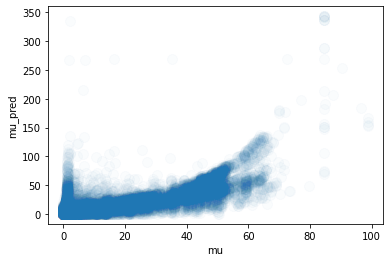

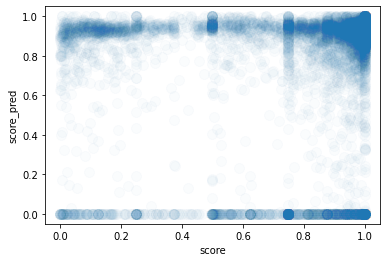

In [13]:
mu_series = pd.Series(result)
mu_series.index = df_user.index
df_user['mu_pred'] = mu_series
df_user['score_pred'] = functional_form.calculate_retention_rate(result,delta_prime[df_user.index])
df.loc[mu_series.index]
df_user.plot.scatter(x='mu', y='mu_pred', s=100, alpha=0.02)
df_user.plot.scatter(x='score', y='score_pred', s=100, alpha=0.02)


/home/charlie/.local/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


mu                  22.000496
mu_pred             23.750301
score                0.861139
score_pred           0.835190
mae                  0.192403
mse                  0.110505
optimism            -0.025950
wmse_tau             0.016724
wmse_delta_tau       0.000141
weighted_bin_acc     0.553494
precision            0.032935
recall               0.238395
dtype: float64

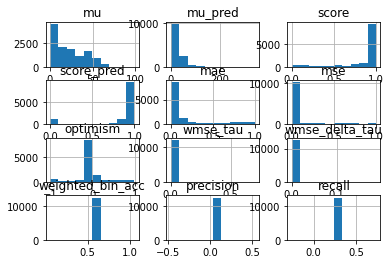

In [14]:
model_performance(df_user).mean()

<ipython-input-15-7419da99f75d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user['score_pred'] = pred_series


<AxesSubplot:xlabel='score', ylabel='score_pred'>

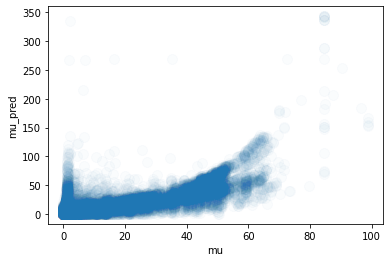

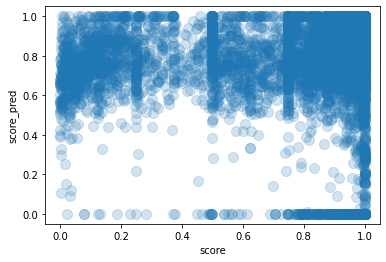

In [15]:
lr_model = LinearRegression()
lr_model.fit(X_general,df_not_user['score'])
pred = lr_model.predict(X_user)
pred_series = pd.Series(np.clip(pred,0,1))
pred_series.index = X_user.index
df_user['score_pred'] = pred_series
df_user.plot.scatter(x='mu', y='mu_pred', s=100, alpha=0.02)
df_user.plot.scatter(x='score', y='score_pred', s=100, alpha=0.2)


/home/charlie/.local/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


mu                  22.000496
mu_pred             23.750301
score                0.861139
score_pred           0.780027
mae                  0.239778
mse                  0.152404
optimism            -0.081113
wmse_tau             0.011919
wmse_delta_tau       0.000176
weighted_bin_acc     0.457316
precision            0.016230
recall               0.117479
dtype: float64

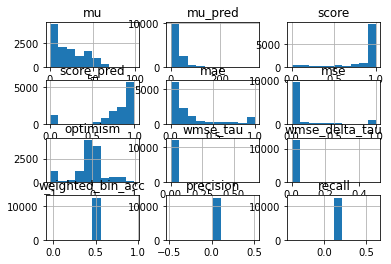

In [16]:
model_performance(df_user).mean()

In [ ]:
df_user.plot.scatter(x='score', y='score_pred', s=100, alpha=0.07)

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()
lr_model.fit(X_general,df_not_user['score']>0.5)
pred = lr_model.predict_proba(X_user)[:,1]
pred_series = pd.Series(np.clip(pred,0,1))
pred_series.index = X_user.index
df_user['score_pred'] = pred_series

In [ ]:
model_performance(df_user).mean()

In [ ]:
summary = model_performance(df_user)

In [ ]:
summary['wmse_tau'].rolling(1000).mean().plot.line()

In [17]:
df[df['score']<0.5]

,TEXT__WORD_HIGHLIGHTED_seconds,TEXT__WORD_HIGHLIGHTED_amount,TEXT__SENTENCE_CLICK_seconds,TEXT__SENTENCE_CLICK_amount,TEXT__SENTENCE_READ_seconds,TEXT__SENTENCE_READ_amount,REVISION__CLICKED_seconds,REVISION__CLICKED_amount,REVISION__NOT_CLICKED_seconds,REVISION__NOT_CLICKED_amount,...,ALL_leading_failures_seconds,ALL_amount,score,score_prev,user_lang,score_pred,mu_pred,mu,delta_scaled,weight
14,62208000,0,62208000,0,62208000,0,158,1,0,1,...,0,3,0.250000,0.500000,charlie_de,1.0,1.0,0.350276,0.003987,0.5
268,62208000,0,62208000,0,62208000,0,88840,1,0,1,...,0,3,0.371567,0.743134,oliver-chao_es,1.0,1.0,0.004945,0.000031,0.5
281,62208000,0,62208000,0,62208000,0,88776,1,0,1,...,0,3,0.371655,0.743309,oliver-chao_es,1.0,1.0,0.004830,0.000031,0.5
288,62208000,0,62208000,0,62208000,0,89294,1,0,2,...,0,6,0.259751,0.871538,oliver-chao_es,1.0,1.0,0.993538,0.017965,0.5
292,62208000,0,62208000,0,62208000,0,89511,1,0,2,...,0,6,0.259302,0.871212,oliver-chao_es,1.0,1.0,0.991345,0.017935,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18428,1045227,1,1045180,3,929585,1,62208000,0,62208000,0,...,856191,66,0.050927,0.173125,charlie_dansk_da,1.0,1.0,0.576553,0.017681,0.5
18429,62208000,0,0,4,643908,6,62208000,0,62208000,0,...,0,703,0.207944,0.982851,charlie_dansk_da,1.0,1.0,0.936969,0.021405,0.5
18430,2939581,2,2939581,16,760371,2,0,8,686655,7,...,610280,2016,0.007642,0.053313,charlie_dansk_da,1.0,1.0,1.064876,0.067685,0.5
18431,62208000,0,62208000,0,62208000,0,29273,5,0,4,...,102149,1275,0.062156,0.538708,charlie_dansk_da,1.0,1.0,1.271251,0.112739,0.5
